# DCG Ranking | nDCG | Precision-Recall Curve

**Imports**

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import nltk
import json
import string
import re

**Load data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
data_file = open("/content/drive/MyDrive/IR_Assignments/MSLRDataset.txt", "r")

Read data from file

In [32]:
with open("/content/drive/MyDrive/IR_Assignments/MSLRDataset.txt") as f:
    lines = f.readlines()

**Preprocessing**

In [33]:
def select_qid4(lines):
    qid4 = []
    for line in lines:
        if line.split(' ')[1] == 'qid:4':
            qid4.append(line)
    return qid4
qid4 = select_qid4(lines)

In [34]:
columns=['relevance_score']
for i in range(1, 137, 1):
    columns.append('feature_' + str(i))

In [35]:
data_rows = []
for entry in qid4:
    row_elements = entry.split(' ')[:-1]
    row = []
    row.append(int(row_elements[0]))
    for element in row_elements[2:]:
        row.append(float(element.split(':')[1]))
    data_rows.append(row)

In [36]:
data = pd.DataFrame(data_rows, columns = columns)

**Sort query-url pairs by max DCG**

In [37]:
data_sorted = data.sort_values(by=['relevance_score'], ascending=False)
data_sorted

,relevance_score,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136
7,3,3.0,0.0,2.0,1.0,3.0,1.000000,0.000000,0.666667,0.333333,...,32.0,349.0,8.0,123.0,281.0,22.0,6.0,0.0,0.0,0.000000
76,2,2.0,0.0,1.0,0.0,2.0,0.666667,0.000000,0.333333,0.000000,...,19.0,0.0,0.0,2417.0,721.0,14.0,113.0,0.0,13.0,47.900000
40,2,3.0,2.0,2.0,0.0,3.0,1.000000,0.666667,0.666667,0.000000,...,33.0,8.0,3.0,1888.0,9338.0,3.0,11.0,0.0,0.0,0.000000
36,2,3.0,0.0,2.0,0.0,3.0,1.000000,0.000000,0.666667,0.000000,...,17.0,0.0,2.0,12028.0,11379.0,26.0,24.0,0.0,77.0,23.959522
90,2,3.0,0.0,3.0,3.0,3.0,1.000000,0.000000,1.000000,1.000000,...,67.0,27.0,0.0,814.0,13555.0,108.0,113.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,0,2.0,0.0,0.0,0.0,2.0,0.666667,0.000000,0.000000,0.000000,...,41.0,8.0,0.0,868.0,9260.0,246.0,88.0,0.0,0.0,0.000000
43,0,2.0,0.0,0.0,0.0,2.0,0.666667,0.000000,0.000000,0.000000,...,38.0,4.0,0.0,797.0,9260.0,237.0,80.0,0.0,0.0,0.000000
42,0,3.0,0.0,3.0,1.0,3.0,1.000000,0.000000,1.000000,0.333333,...,65.0,83.0,5.0,144.0,262.0,157.0,179.0,0.0,0.0,0.000000
41,0,3.0,1.0,3.0,2.0,3.0,1.000000,0.333333,1.000000,0.666667,...,65.0,195.0,8.0,124.0,206.0,103.0,121.0,0.0,0.0,0.000000


In [39]:
data_sorted.to_csv("/content/drive/MyDrive/IR_Assignments/MSLRDataset_DCGRanked.csv")

**Number of possible files**

In [40]:
def count_files(data):
    num4 = (data['relevance_score'] == 4).sum()
    num3 = (data['relevance_score'] == 3).sum()
    num2 = (data['relevance_score'] == 2).sum()
    num1 = (data['relevance_score'] == 1).sum()
    num0 = (data['relevance_score'] == 0).sum()
    return math.factorial(num0)*math.factorial(num1)*math.factorial(num2)*math.factorial(num3)*math.factorial(num4)

num_files = count_files(data)

In [41]:
print('Number of possible files ranked in order of max DCG: ', num_files)

Number of possible files ranked in order of max DCG:  19893497375938370599826047614905329896936840170566570588205180312704857992695193482412686565431050240000000000000000000000


**nDCG**

In [93]:
def dcg(data, n):
    dcg = 0
    for i in range(0, n, 1):
        if i == 0:
            dcg += data.iloc[i, 0]
        else:
            dcg += data.iloc[i, 0]/math.log(i+1, 2)
    return dcg

def ndcg(data, data2, n):
    dcg1 = dcg(data, n)
    dcg2 = dcg(data2, n)
    ndcg = dcg2/dcg1
    return ndcg

In [42]:
data_sorted_75 = data.sort_values(by=['feature_75'], ascending=False)
data_sorted_75

,relevance_score,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136
8,0,3.0,0.0,3.0,0.0,3.0,1.000000,0.000000,1.000000,0.000000,...,51.0,766.0,0.0,119.0,32560.0,45.0,24.0,0.0,0.0,0.000000
67,0,3.0,0.0,3.0,2.0,3.0,1.000000,0.000000,1.000000,0.666667,...,61.0,0.0,9.0,120.0,392.0,162.0,169.0,0.0,0.0,0.000000
56,0,3.0,1.0,3.0,1.0,3.0,1.000000,0.333333,1.000000,0.333333,...,48.0,189.0,8.0,549.0,2650.0,91.0,114.0,0.0,0.0,0.000000
1,0,3.0,0.0,3.0,0.0,3.0,1.000000,0.000000,1.000000,0.000000,...,61.0,0.0,8.0,122.0,508.0,131.0,136.0,0.0,0.0,0.000000
101,1,2.0,0.0,2.0,0.0,2.0,0.666667,0.000000,0.666667,0.000000,...,23.0,0.0,1.0,42877.0,26562.0,12.0,24.0,0.0,56.0,62.920604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0,2.0,0.0,0.0,0.0,2.0,0.666667,0.000000,0.000000,0.000000,...,19.0,0.0,2.0,59949.0,22708.0,5.0,6.0,0.0,391.0,28.267114
16,0,3.0,0.0,0.0,0.0,3.0,1.000000,0.000000,0.000000,0.000000,...,48.0,2.0,2.0,144.0,1917.0,19.0,119.0,0.0,0.0,0.000000
86,0,3.0,0.0,0.0,0.0,3.0,1.000000,0.000000,0.000000,0.000000,...,34.0,43.0,2.0,3262.0,1859.0,20.0,165.0,0.0,0.0,0.000000
49,0,1.0,0.0,1.0,0.0,1.0,0.333333,0.000000,0.333333,0.000000,...,24.0,11.0,0.0,9040.0,8756.0,51.0,17.0,0.0,10.0,20.133333


nDCG for given dataset ranking

In [94]:
at50 = ndcg(data_sorted, data, 50)
full_dataset = ndcg(data_sorted, data, data.shape[0])

In [95]:
print('nDCG at 50: ', at50)

nDCG at 50:  0.3521042740324887


In [96]:
print('nDCG for the whole dataset: ', full_dataset)

nDCG for the whole dataset:  0.5979226516897831


nDCG for data sorted by feature 75

In [83]:
at50 = ndcg(data_sorted, data_sorted_75, 51)
full_dataset = ndcg(data_sorted, data_sorted_75, data.shape[0])

In [84]:
print('nDCG at 50: ', at50)

nDCG at 50:  0.5117717307035755


In [85]:
print('nDCG for the whole dataset: ', full_dataset)

nDCG for the whole dataset:  0.7299636618842381


**Precision-Recall Curve**

In [ ]:
def calc_precision_recall(data):
    precision = []
    recall = []
    numrows = data.shape[0]
    tot_relevant = numrows - (data['relevance_score'] == 0).sum()
    relevant_ctr = 0
    for i in range(1, numrows, 1):
        if data.iloc[i, 0] != 0:
            relevant_ctr += 1
        precision.append(relevant_ctr/(i+1))
        recall.append(relevant_ctr/tot_relevant)  

    return precision, recall

precision, recall = calc_precision_recall(data_sorted_75)

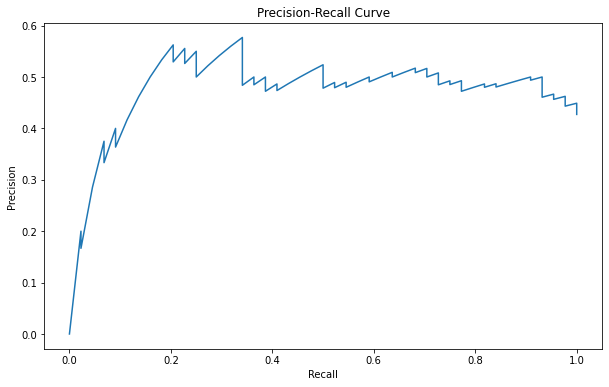

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

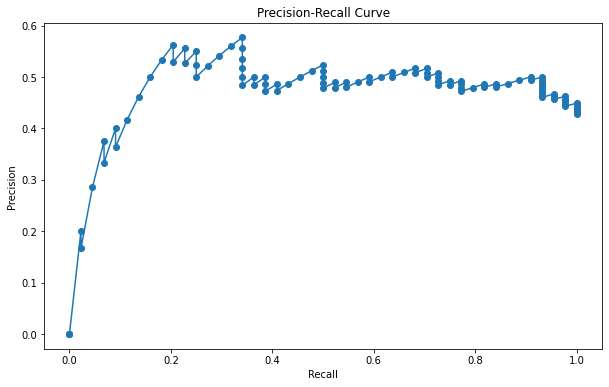

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(recall, precision, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()